In [41]:
!pip install -q fastbook

In [42]:
from fastai.vision.all import *

import fastbook
fastbook.setup_book()

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in dl-lab2
- `Resize(420)` as item transform
- A size of 224 in the batch transforms
- Use `set_seed()` to obtain reproducible results.
- Augmentations using `aug_transforms()` with `min_scale` and `mult` set to a value that creates resonable augmentations (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [43]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')
export_path.ls()
path = export_path/'digits'


In [44]:
set_seed(625,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(size = 420),
                 batch_tfms=aug_transforms(size=224, p_lighting = 1, min_scale=1, mult = 0.5)) 
dls = digits.dataloaders(path)

print(dls)

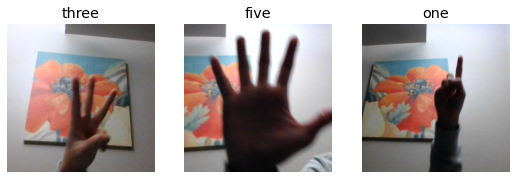

In [45]:
dls.train.show_batch(nrows = 1, ncols = 3)

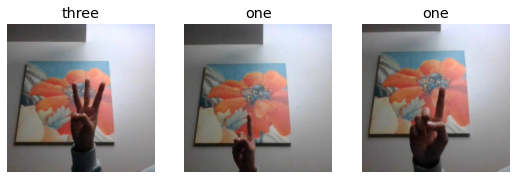

In [46]:
dls.valid.show_batch(nrows = 1, ncols = 3)

### Question 1: Which `min_scale` and `mult` values did you choose for augmentations? Can you spot any problems in the training set augmentations, e.g. finger digits missing?
I used min_scale = 1.5 and mult = 0.25 because when running through smaller min_scale and higher mult, the validation set of 5 is out of frame. 


# 2. Train the classifier

## 2.1 Impact of learning rate
With:
- Same `set_seed()` as above
- Re-creating the same DataLoaders as above
- ResNet18 architecture.
- accuracy as metric.

Use the learning rate finder and identify three learning rates:
- small: In the flat region prior to descending
- medium: What the textbook would recommend
- large: Close to the minimum of the learning rate finder

Train the model with each learning rate using `fine_tune` with 15 epochs


In [47]:
set_seed(625,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(size = 420),
                 batch_tfms=aug_transforms(size=224, p_lighting = 1, min_scale=1, mult = 0.5)) 
dls = digits.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=accuracy)


Minimum/10:	2.09e-02
Steepest point:	2.09e-03
Longest valley:	1.74e-03
Slide interval:	1.20e-03


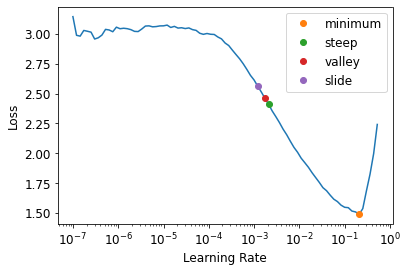

In [48]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10:\t{lr_min:.2e}")
print(f"Steepest point:\t{lr_steep:.2e}")
print(f"Longest valley:\t{lr_valley:.2e}")
print(f"Slide interval:\t{lr_slide:.2e}")

Small learning rate at 1e-5

In [49]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,3.024144,2.972750,0.160000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,2.995158,2.482088,0.120000,00:05
1,3.117848,2.253278,0.160000,00:03
2,3.068694,2.130496,0.140000,00:03
3,2.998997,2.073069,0.180000,00:06
4,2.936146,2.069836,0.120000,00:04
5,2.962403,2.083047,0.140000,00:03
6,2.969524,2.074811,0.180000,00:03
7,2.947042,2.074580,0.240000,00:05
8,2.952332,2.068836,0.200000,00:03
9,2.928622,2.079086,0.220000,00:03


Medium learning rate at 1.74e-3

In [50]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=1.74e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.876068,2.351050,0.320000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.961596,1.571795,0.420000,00:03
1,1.761095,1.102106,0.600000,00:03
2,1.565999,0.818145,0.640000,00:05
3,1.399766,0.489141,0.840000,00:03
4,1.273036,0.344324,0.860000,00:03
5,1.119314,0.275686,0.900000,00:04
6,0.981452,0.294136,0.900000,00:04
7,0.874485,0.307166,0.920000,00:03
8,0.788105,0.294601,0.900000,00:03
9,0.723069,0.281075,0.900000,00:04


Large learning rate at 2e-2

In [51]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(15, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.130210,2.979326,0.620000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.169632,1.895336,0.640000,00:04
1,0.872879,1.260434,0.720000,00:04
2,0.714624,3.115062,0.700000,00:03
3,0.600368,3.394980,0.680000,00:03
4,0.570549,0.439595,0.900000,00:05
5,0.520803,0.352236,0.920000,00:03
6,0.456058,1.908726,0.760000,00:03
7,0.437965,0.468670,0.900000,00:03
8,0.389417,0.509744,0.940000,00:05
9,0.354203,0.626298,0.920000,00:03


### Question 2: Which training run resulted in the best model? State final accuracy values for all learning rates and identify the best model. 
Final accuracy for learning rate of 1e-5, which is the smallest one, is 28%. It increases to 90% for higher learning rate of 1.74e-3 and maximize at 94% for the best learning rate of 2e-2.


### Question 3: Did any models overfit? Include your reasoning. 
The smallest and largest learning rates are probably overfit. For the largest chosen learning rate, the training and validation score fluctuates and never seems to be stable while the gap between those scores for the smallest learning rate is high 


## 2.2 Impact of freeze epoch
With:
- Same `set_seed()` as above
- Re-creating the same DataLoaders as above
- ResNet18 architecture.
- accuracy as metric.
- learning rate of the best model from above

Create three model training with `fine_tune()` that use different combinations of `freeze_epochs` and `epochs` with the total number of epochs not exceeding 16 (number of epochs from the previous section).

In [52]:
set_seed(625,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(size = 420),
                 batch_tfms=aug_transforms(size=224, p_lighting = 1, min_scale=1, mult = 0.5)) 
dls = digits.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=accuracy)

In [53]:
learn.fine_tune(13, freeze_epochs = 3, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.471887,2.789898,0.320000,00:05
1,1.751802,1.355793,0.680000,00:03
2,1.460925,1.817975,0.640000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.682581,0.778868,0.840000,00:04
1,0.633604,0.305681,0.900000,00:04
2,0.500109,0.846036,0.820000,00:04
3,0.534442,3.803613,0.740000,00:04
4,0.602973,5.164791,0.760000,00:05
5,0.583174,1.293950,0.780000,00:04
6,0.509600,0.688464,0.900000,00:04
7,0.467838,0.217727,0.940000,00:05
8,0.410911,0.732771,0.880000,00:03
9,0.372723,0.506798,0.900000,00:03


In [54]:
learn.fine_tune(12, freeze_epochs = 4, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.031569,0.053717,0.960000,00:03
1,0.045015,0.155752,0.940000,00:05
2,0.045189,0.176060,0.940000,00:03
3,0.062894,0.266595,0.960000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.021352,0.730869,0.840000,00:03
1,0.026891,1.337190,0.820000,00:05
2,0.080553,0.667037,0.900000,00:03
3,0.182599,0.434276,0.900000,00:03
4,0.216270,2.582430,0.740000,00:05
5,0.243574,4.617965,0.640000,00:07
6,0.240823,5.175586,0.640000,00:03
7,0.229712,3.152182,0.720000,00:04
8,0.218618,0.906315,0.820000,00:03
9,0.206788,0.068412,0.980000,00:03


In [55]:
learn.fine_tune(11, freeze_epochs = 5, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.029178,0.081436,0.980000,00:03
1,0.033999,0.093447,0.980000,00:03
2,0.028896,0.145270,0.960000,00:03
3,0.030104,0.228562,0.960000,00:04
4,0.032354,0.184384,0.980000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.059172,0.013822,1.000000,00:03
1,0.128091,0.256274,0.960000,00:04
2,0.128677,0.845553,0.880000,00:04
3,0.162135,0.081025,0.980000,00:03
4,0.156501,0.402463,0.920000,00:03
5,0.136315,0.422515,0.880000,00:05
6,0.139623,0.115582,0.980000,00:03
7,0.143745,0.038056,0.980000,00:03
8,0.133539,0.048667,0.980000,00:03
9,0.123182,0.061838,0.980000,00:05


### Question 4: Did any of these models outperform the models in Section 2.1? State final accuracy values for epoch combinations and identify the best model, compare to best model in section 2.1. 
These models are performing the same and even better when comparing the accuracy. with the best model produce accuracy of 98%, when freeze epochs equals to 5. Comparing to the best model with learning rate of 2e-2, the accuracy percentage increases by 4%. With freeze epochs of 3 and 4, the models produce 94% and 90% respectively.


### Question 5: Did any models overfit? Include your reasoning. 
At 5 frozen epochs, training loss is decreasing while valid loss goes back up a little bit then we are probably overfitting it. Same situation happens for 4 frozen epochs


# 3. Analyze model performance
- Retrain the best model from above.
- Plot the confusion matrix.
- Plot 10 top losses

In [56]:
set_seed(625,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(size = 420),
                 batch_tfms=aug_transforms(size=224, p_lighting = 1, min_scale=1, mult = 0.5)) 
dls = digits.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(11, freeze_epochs = 5, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.508378,2.678300,0.280000,00:03
1,1.826724,1.302482,0.620000,00:04
2,1.490505,1.334544,0.680000,00:04
3,1.241383,1.176255,0.780000,00:03
4,1.049717,1.093685,0.860000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.438337,0.766456,0.860000,00:05
1,0.482363,4.728225,0.520000,00:03
2,0.552430,1.135075,0.880000,00:03
3,0.600400,6.660174,0.540000,00:03
4,0.537027,0.735603,0.860000,00:05
5,0.487851,2.111119,0.760000,00:03
6,0.428779,2.167598,0.700000,00:03
7,0.374682,1.705463,0.720000,00:04
8,0.331492,0.997971,0.780000,00:04
9,0.313600,0.496183,0.880000,00:03


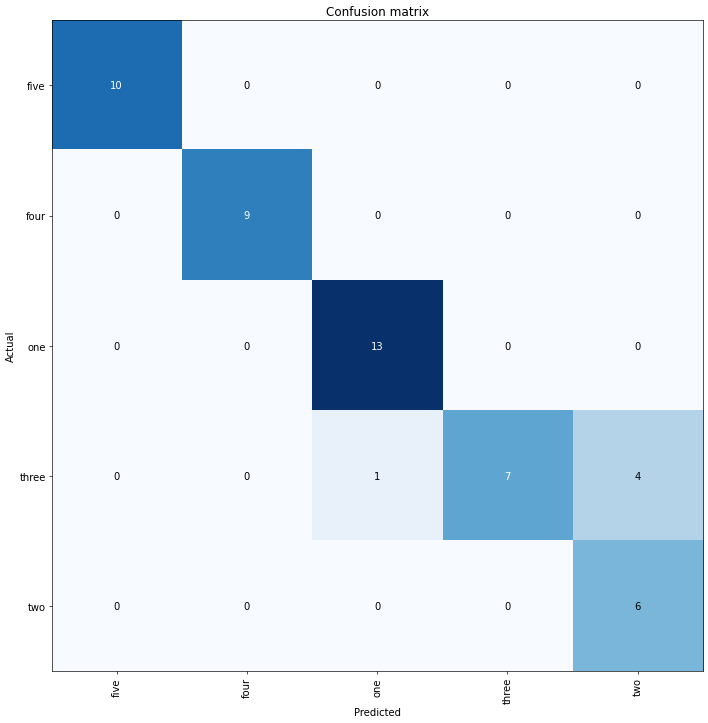

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

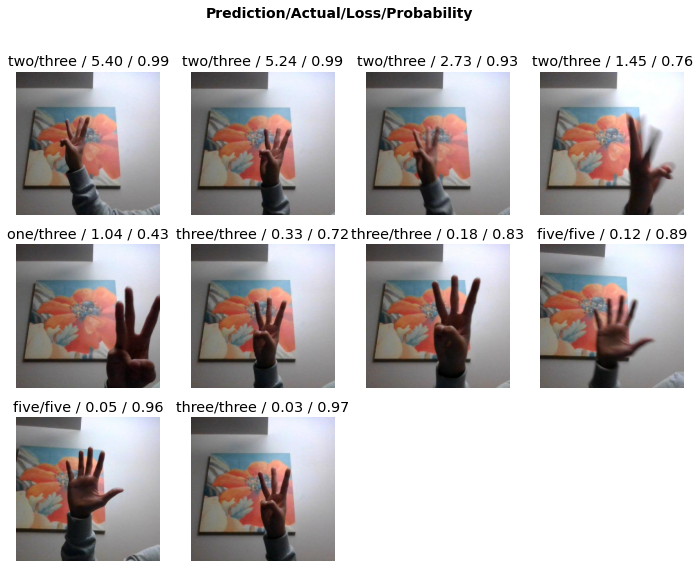

In [59]:
interp.plot_top_losses(10)

### Question 6: With which finger digits does your model have the most problems with? 
Digits 3 is the most problematic. The model incorrectly predicts digts 3 five different times, mistaking it with four and two images.

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [64]:
learn.export(fname=(export_path/"models/digits.pkl"))
learn.path = export_path
learn.save("digits")
[item for item in (export_path/"models").ls() if "digits" in str(item)]

[Path('/content/gdrive/MyDrive/Colab Notebooks/models/digits.pkl'),
 Path('/content/gdrive/MyDrive/Colab Notebooks/models/digits.pth')]

Show predictions

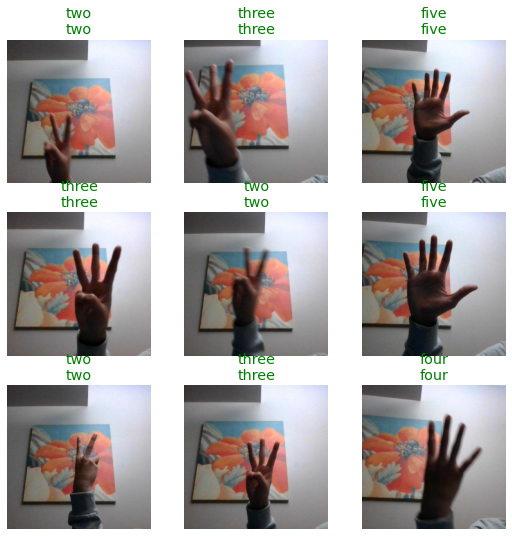

In [67]:
set_seed(625,True)
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(size = 420),
                 batch_tfms=aug_transforms(size=224, p_lighting = 1, min_scale=1, mult = 0.5)) 
dls = digits.dataloaders(path)

learn_saved = vision_learner(dls, resnet18, metrics=accuracy)
learn_saved.load('/content/gdrive/MyDrive/Colab Notebooks/models/digits')
learn_saved.show_results()

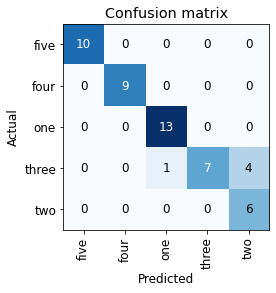

In [68]:
interp = ClassificationInterpretation.from_learner(learn_saved)
interp.plot_confusion_matrix()

# 5. Summary and Conclusion

Summarize the best model:
- Training strategy: learning rate and epochs used.
- Accuracy achieved, summary of confusion matrix, i.e. what kind of errors does the model make.

The best strategy is using 5 freeze epochs, it produces the accuracy of 98% with the learning rate of 2e-2. The only problem it is struggling with is to predict digit 3 images. Those images are often confused with digits 2, with 4 times predicted wrong based on the confusion matrix. 


Conclusion:
- Are you satisfied with model performance? Why, why not?

The models are often overfitting so it is not really the best one. There is a lot of room for improvement


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

The lab really requires a lot of knowledge that is applicable for the future. I had to work through every notes in order to finish it so it is a interesting and useful lab. 
